In [4]:
from selenium.webdriver.common.by import By
import time

In [5]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup

In [6]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# Part I Scraping

In [ ]:
# SCROLLING MECHANISM
# --------------------

# Opening web browser and website
driver = webdriver.Chrome()
driver.maximize_window()

# Changing url manually for different positions and different countries
url = "https://ca.linkedin.com/jobs/search?keywords=Data%2BAnalytics&location=Canada&geoId=101174742&trk=public_jobs_jobs-search-bar_search-submit&currentJobId=3797108685&position=1&pageNum=0"
driver.get(url)

# Scrolling to the very bottom
for i in range(0,45): # Why 45? It doesn't go lower than that
    try:
        # Show more jobs button
        driver.find_element(By.CLASS_NAME, 'infinite-scroller__show-more-button').click()
        time.sleep(4)
    except:
        pass
    #Scroll to the bottom
    driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
    time.sleep(3)
    
    
# EXTRACTING THE DATA
# -------------------
      
# Creating a soup
page_source = driver.page_source
soup = BeautifulSoup(page_source)

# Searching for all the jobs
jobs = soup.find_all('div', class_ = 'base-card')
joblist = []

# Looping through jobs and extracting STATIC data with Beautiful soup
for job in jobs:
    
    title = job.find('h3', class_ ="base-search-card__title").get_text().strip()
    company = job.find('a', class_ ="hidden-nested-link").get_text().strip()
    location = job.find('span', class_ ="job-search-card__location").get_text().strip()
    try:
        date = job.find('time', class_ ="job-search-card__listdate").get_text().strip()
    except:
        date = 'New'
    try:
        salary = job.find('span', class_ ="job-search-card__salary-info").get_text().strip()
    except:
        salary = ''
        
    # Creating a dictionary with job's data  
    job = {
        'title' : title,
        'company' : company,
        'location' : location,
        'date' : date,
        'salary' : salary
    }
    # Adding job to the list
    joblist.append(job)
    
# All the jobs with Selenium (to be able to click on each of them and retrieve job description)
posts = driver.find_elements(By.CLASS_NAME, 'base-card__full-link')  

# Index to navigate through joblist later    
n = 0

# Opening every job description
for post in posts:
    post.click() 
    time.sleep(2)
    
    # Scroll to the 'show more' button (sometimes it's located lower and therefore not visible)
    div_element = driver.find_element(By.CLASS_NAME, 'show-more-less-html__button')
    driver.execute_script("arguments[0].scrollIntoView(true);", div_element)
    time.sleep(2)  

    try:
        # Click on 'Show more' button (to access job's description)
        driver.find_element(By.CLASS_NAME, 'show-more-less-html__button').click()
        time.sleep(2) 
        
        # Extracting description and seniority level 
        seniority_level = driver.find_element(By.CLASS_NAME, 'description__job-criteria-text').text
        description = driver.find_element(By.CLASS_NAME, "show-more-less-html__markup").text.replace('\n',' ')
        
        # Adding information to job dictionaries
        joblist[n]['seniority_level'] = seniority_level
        joblist[n]['description'] = description
        n += 1
    except:
        # Sometimes there is lag and button doesn't work(even manually). In this case we skip this job post.
        # (it will have null values in those columns later)
        joblist[n]['seniority_level'] = ''
        joblist[n]['description'] = ''
        n += 1

# Part II - Working with data

## Loading and cleaning 

In [10]:
# Data Science US
ds_us = pd.read_csv('C:\\Users\\kondr\\Downloads\\WCD\\3. Pandas\\Scraping\\Datasets\\Data Scientist US.csv')
ds_us  = ds_us.copy()
# ds_us = ds_us.drop('Unnamed: 0', axis='columns')
# ds_us = ds_us.drop_duplicates()
# ds_us = ds_us.reset_index()
# ds_us = ds_us.drop('index', axis='columns')

In [11]:
# Data Science Canada
ds_ca = pd.read_csv('C:\\Users\\kondr\\Downloads\\WCD\\3. Pandas\\Scraping\\Datasets\\Data Scientist Canada.csv')
ds_ca  = ds_ca.copy()

In [12]:
# Data Analyst US
da_us = pd.read_csv('C:\\Users\\kondr\\Downloads\\WCD\\3. Pandas\\Scraping\\Datasets\\Data Analyst US.csv')
da_us  = da_us.copy()

In [13]:
# Data Analyst Canada
da_ca = pd.read_csv('C:\\Users\\kondr\\Downloads\\WCD\\3. Pandas\\Scraping\\Datasets\\Data Analyst Canada.csv')
da_ca = da_ca.copy()

In [14]:
# Data Engineer US
de_us = pd.read_csv('C:\\Users\\kondr\\Downloads\\WCD\\3. Pandas\\Scraping\\Datasets\\Data Engineer US.csv')
de_us = de_us.copy()

In [15]:
# Data Engineer Canada
de_ca = pd.read_csv('C:\\Users\\kondr\\Downloads\\WCD\\3. Pandas\\Scraping\\Datasets\\Data Engineer Canada.csv')
de_ca = de_ca.copy()

#### Creating one file

In [16]:
df = pd.concat([ds_us, ds_ca, da_us, da_ca, de_us, de_ca])

#### Cleaning

In [17]:
df = df.copy()
df = df.drop('Unnamed: 0', axis='columns')
df = df.drop('salary', axis='columns')
df = df.drop_duplicates()
df = df.reset_index()
df = df.drop('index', axis='columns')

#### Object to string type

In [18]:
df['title'] = df['title'].astype('string')
df['company'] = df['company'].astype('string')
df['location'] = df['location'].astype('string')
df['date'] = df['date'].astype('string')
df['seniority_level'] = df['seniority_level'].astype('string')
df['description'] = df['description'].astype('string')

#### Checking dataset

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4833 entries, 0 to 4832
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            4833 non-null   string
 1   company          4833 non-null   string
 2   location         4833 non-null   string
 3   date             4833 non-null   string
 4   seniority_level  3911 non-null   string
 5   description      3911 non-null   string
dtypes: string(6)
memory usage: 226.7 KB


## Creating new columns

#### Spliting jobs into Data Analyst, Data Scientist, Data Engineer categories (based on the title) and creating new column 'categories'


In [20]:
category = []

for title in df['title']:
    if 'anal' in title.lower():
        category.append('Data Analyst')
    elif ('scien' or 'research') in title.lower():
        category.append('Data Scientist')
    elif ('ml' or 'machine') in title.lower():
        category.append('Machine Learning')
    elif ('software' or 'developer') in title.lower():
        category.append('Software Developer')
    elif ('engineer' or 'de') in title.lower():
        category.append('Data Engineer')
    else:
        category.append('Rest') 
        
df['category'] = category

#### Searching for degree and creating new column 'degrees'

In [36]:
bachelor_pattern = re.compile(r"\b(bachelor|undergraduate)\b",flags=re.IGNORECASE)
master_pattern = re.compile(r"\b(master)\b",flags=re.IGNORECASE)
phd_pattern = re.compile(r"\b(phd)\b",flags=re.IGNORECASE)
degree = []

for index,value in enumerate(df['description']): 
#     if pd.notnull(value): -- need to handle null values in description, because it gives 'Not mentioned' for nulls and messes up the insight
    if re.search(bachelor_pattern,str(value)):
        degree.append('Bachelor')
    elif re.search(master_pattern,str(value)):
        degree.append('Master')
    elif re.search(master_pattern,str(value)):
        degree.append('Phd')
    else:
        degree.append("Not mentioned")
    
df['degree'] = degree

#### Creating a df without null values in description. Will need it for degree visualization. (if use original df, it will show more 'Not mentioned' degrees, because of the condition logic (see the cell above)). Other visualizations can be done with original df

In [ ]:
degree_df = df[pd.notnull(df)['description']]
degree_df = degree_df.reset_index()
degree_df = degree_df.drop('index',axis='columns')
degree_df

#### Searching for required technical skills and creating new column 'skills'

In [81]:
buzz_words = ['sql', 'hadoop', 'linux', 'azure', 'python', 'pandas', 'tableau', 'oracle', 'excel', 'cloud', 'aws', 'databricks', 'sap', 'sas', 'nlp', 'tensorflow', 'pytorch', 'spark', 'airflow', 'snowflake', 'gcp', 'java', 'redshift', 'kafka', 'nosql', 'scala', 'kubernetes', 'docker']

df['skills'] = ''
n=0


for info in df[pd.notnull(df['description'])]['description']:
    skills = []
    for word in buzz_words:
        if word in info.lower():
            df['skills'][n] = df['skills'][n] + word + ' '
    n+=1


C:\Users\kondr\AppData\Local\Temp\ipykernel_21448\3716063235.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skills'][n] = df['skills'][n] + word + ' '


In [82]:
# Converting skills column values from string to list
df['skills'] = df['skills'].apply(lambda x: x[:-1].split(' '))

#### Counting technical skills per category

In [83]:
data_analyst = df[df['category'] == 'Data Analyst']
data_scientist = df[df['category'] == 'Data Scientist']
data_engineer = df[df['category'] == 'Data Engineer']

skills_count_da = {'sql':0, 'hadoop':0, 'linux':0, 'azure':0, 'python':0, 'pandas':0, 'tableau':0, 'oracle':0, 'excel':0, 'cloud':0, 'aws':0, 'databricks':0, 'sap':0, 'sas':0, 'nlp':0, 'tensorflow':0, 'pytorch':0, 'spark':0, 'airflow':0, 'snowflake':0, 'gcp':0, 'java':0, 'redshift':0, 'kafka':0, 'nosql':0, 'scala':0, 'kubernetes':0, 'docker':0   }
skills_count_ds = {'sql':0, 'hadoop':0, 'linux':0, 'azure':0, 'python':0, 'pandas':0, 'tableau':0, 'oracle':0, 'excel':0, 'cloud':0, 'aws':0, 'databricks':0, 'sap':0, 'sas':0, 'nlp':0, 'tensorflow':0, 'pytorch':0, 'spark':0, 'airflow':0, 'snowflake':0, 'gcp':0, 'java':0, 'redshift':0, 'kafka':0, 'nosql':0, 'scala':0, 'kubernetes':0, 'docker':0   }
skills_count_de = {'sql':0, 'hadoop':0, 'linux':0, 'azure':0, 'python':0, 'pandas':0, 'tableau':0, 'oracle':0, 'excel':0, 'cloud':0, 'aws':0, 'databricks':0, 'sap':0, 'sas':0, 'nlp':0, 'tensorflow':0, 'pytorch':0, 'spark':0, 'airflow':0, 'snowflake':0, 'gcp':0, 'java':0, 'redshift':0, 'kafka':0, 'nosql':0, 'scala':0, 'kubernetes':0, 'docker':0   }


# Counting Data Analyst skills
for skills in data_analyst['skills']:
    for word in skills:
        if word in skills_count_da:
            skills_count_da[word] +=1

# Counting Data Scientist skills
for skills in data_scientist['skills']:
    for word in skills:
        if word in skills_count_ds:
            skills_count_ds[word] +=1

# Counting Data Engineering skills
for skills in data_engineer['skills']:
    for word in skills:
        if word in skills_count_de:
            skills_count_de[word] +=1
            
# Sorting dictionaries
skills_count_da = dict(sorted(skills_count_da.items(), key=lambda item: item[1]))  
skills_count_ds = dict(sorted(skills_count_ds.items(), key=lambda item: item[1]))       
skills_count_de = dict(sorted(skills_count_de.items(), key=lambda item: item[1]))       

## Visualizations

###  Required skills plots

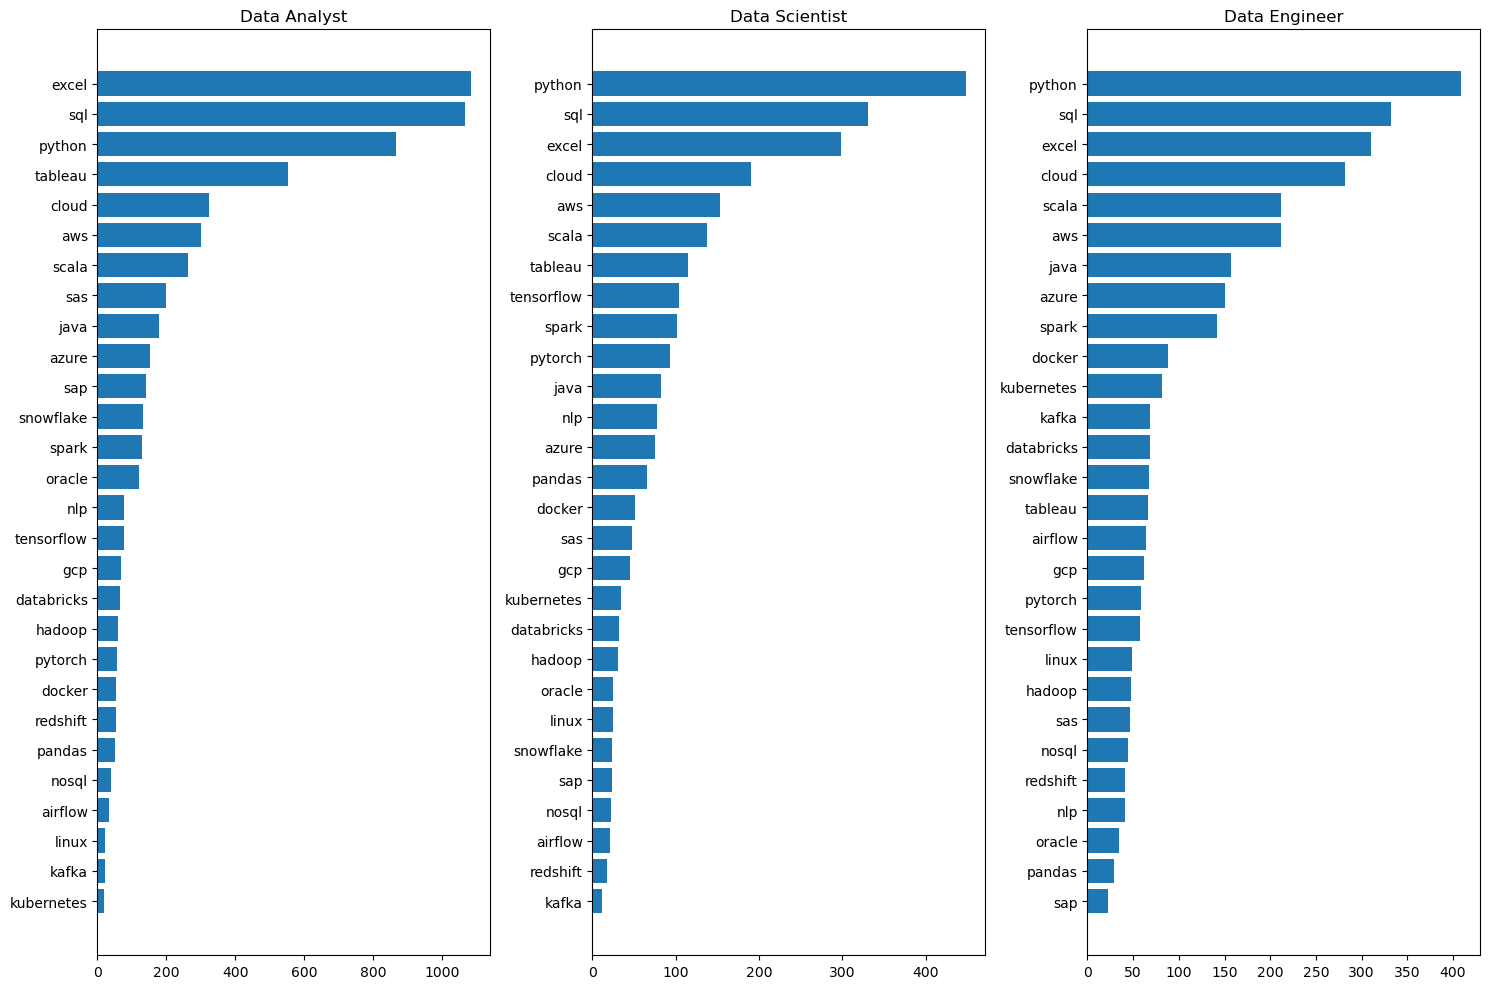

In [84]:
da_x = list(skills_count_da.keys())
da_y = list(skills_count_da.values())

ds_x = list(skills_count_ds.keys())
ds_y = list(skills_count_ds.values())

de_x = list(skills_count_de.keys())
de_y = list(skills_count_de.values())


fig, axs = plt.subplots(1,3, figsize=(15, 10))

axs[0].barh(da_x, da_y)
axs[0].set_title('Data Analyst')

axs[1].barh(ds_x, ds_y)
axs[1].set_title('Data Scientist')

axs[2].barh(de_x, de_y)
axs[2].set_title('Data Engineer')

fig.tight_layout();

### Postings per city plot (top 10)

#### Data Analyst

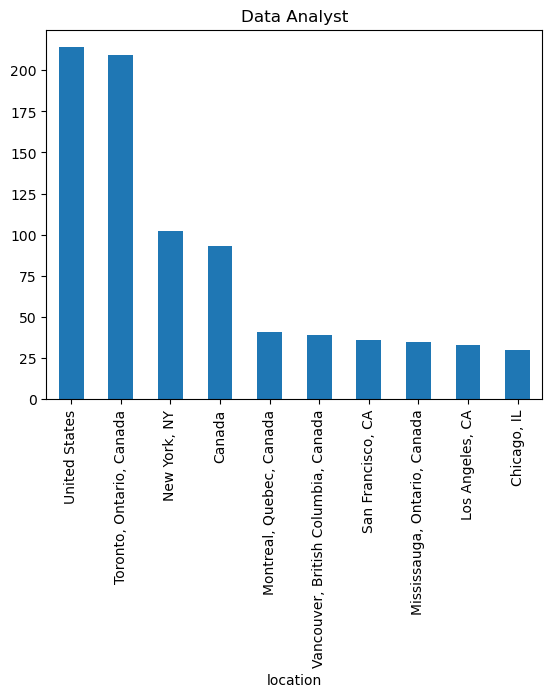

In [85]:
df[df['category'] == 'Data Analyst'].value_counts('location').head(10).plot(kind='bar', title= 'Data Analyst');

#### Data Scientist

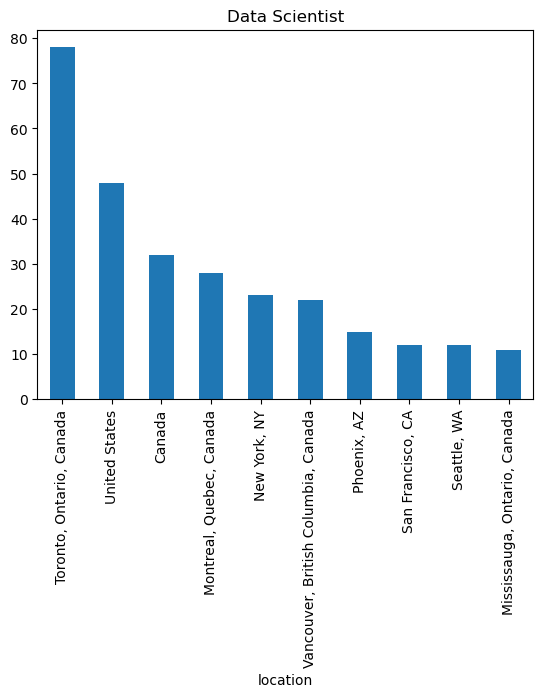

In [103]:
df[df['category'] == 'Data Scientist'].value_counts('location').head(10).plot(kind='bar', title= 'Data Scientist');

#### Data Engineer

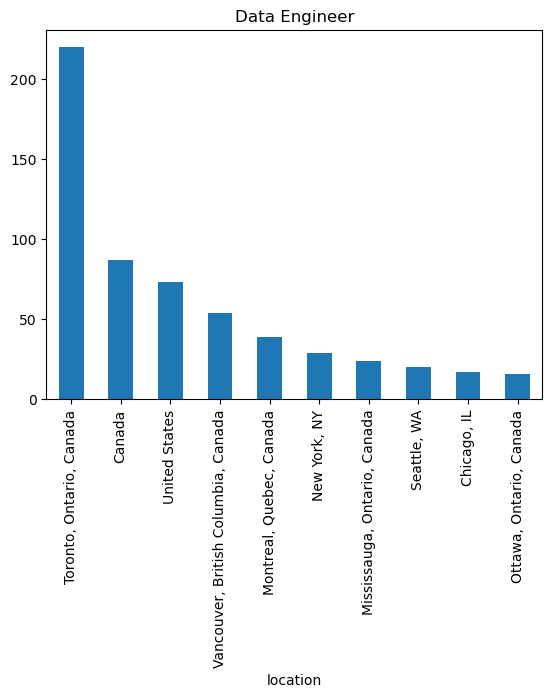

In [87]:
df[df['category'] == 'Data Engineer'].value_counts('location').head(10).plot(kind='bar', title= 'Data Engineer');

### Required degrees plot

#### Data Analyst

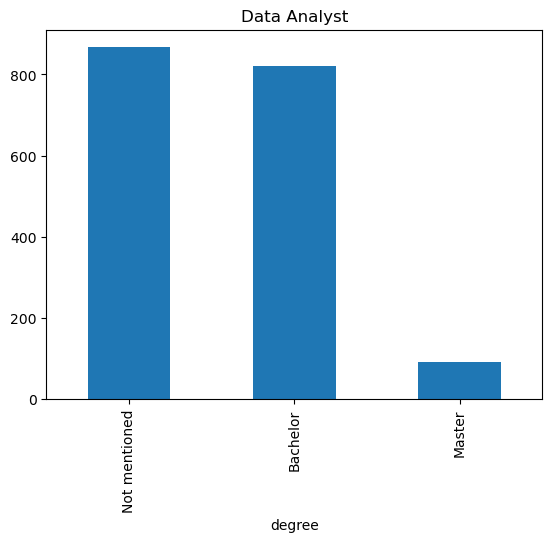

In [46]:
degree_df[degree_df['category'] == 'Data Analyst'].value_counts('degree').plot(kind='bar', title= 'Data Analyst');

#### Data scientist

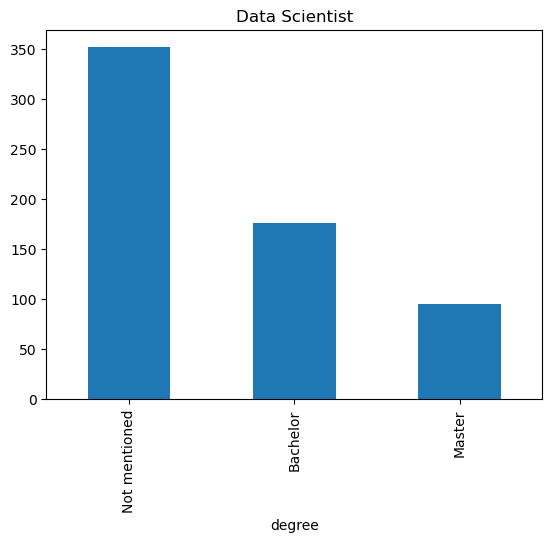

In [47]:
degree_df[degree_df['category'] == 'Data Scientist'].value_counts('degree').plot(kind='bar', title= 'Data Scientist');


#### Data Engineer

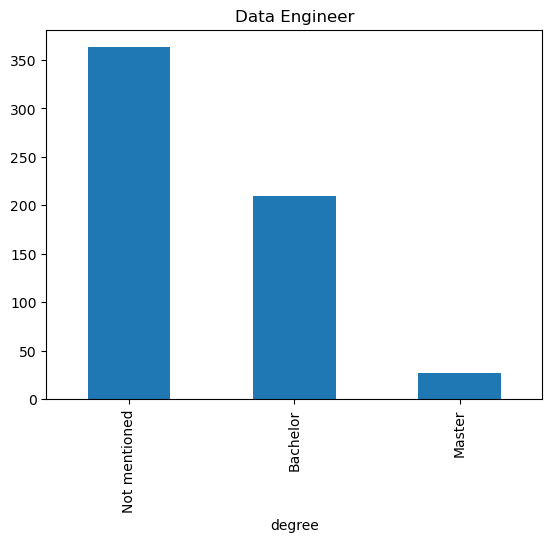

In [48]:
degree_df[degree_df['category'] == 'Data Engineer'].value_counts('degree').plot(kind='bar', title= 'Data Engineer');

### Last week/month job postings

#### Last week job postings


In [91]:
data_analyst = df[df['category'] == 'Data Analyst']
data_scientist = df[df['category'] == 'Data Scientist']
data_engineer = df[df['category'] == 'Data Engineer']

new = df['date'] == 'New'

day_ago = df['date'] == '1 day ago'
days2_ago = df['date'] == '2 days ago'
days3_ago = df['date'] == '3 days ago'
days4_ago = df['date'] == '4 days ago'
days5_ago = df['date'] == '5 days ago'
days6_ago = df['date'] == '6 days ago'

week_ago = df['date'] == '1 week ago'

last_week_da = len(data_analyst[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago])
last_week_de = len(data_engineer[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago])
last_week_ds = len(data_scientist[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago])

C:\Users\kondr\AppData\Local\Temp\ipykernel_21448\3597625858.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_week_da = len(data_analyst[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago])
C:\Users\kondr\AppData\Local\Temp\ipykernel_21448\3597625858.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_week_de = len(data_engineer[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago])
C:\Users\kondr\AppData\Local\Temp\ipykernel_21448\3597625858.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_week_ds = len(data_scientist[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago])


#### Last month job postings


In [92]:
data_analyst = df[df['category'] == 'Data Analyst']
data_scientist = df[df['category'] == 'Data Scientist']
data_engineer = df[df['category'] == 'Data Engineer']

new = df['date'] == 'New'

day_ago = df['date'] == '1 day ago'
days2_ago = df['date'] == '2 days ago'
days3_ago = df['date'] == '3 days ago'
days4_ago = df['date'] == '4 days ago'
days5_ago = df['date'] == '5 days ago'
days6_ago = df['date'] == '6 days ago'

week_ago = df['date'] == '1 week ago'
weeks2_ago = df['date'] == '2 weeks ago'
weeks3_ago = df['date'] == '3 weeks ago'
weeks4_ago =df['date'] == '4 weeks ago'
month_ago = df['date'] == '1 month ago'

last_month_da = len(data_analyst[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago | weeks2_ago | weeks3_ago | weeks4_ago])
last_month_de = len(data_engineer[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago | weeks2_ago | weeks3_ago | weeks4_ago])
last_month_ds = len(data_scientist[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago | weeks2_ago | weeks3_ago | weeks4_ago])

C:\Users\kondr\AppData\Local\Temp\ipykernel_21448\999973906.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_month_da = len(data_analyst[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago | weeks2_ago | weeks3_ago | weeks4_ago])
C:\Users\kondr\AppData\Local\Temp\ipykernel_21448\999973906.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_month_de = len(data_engineer[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago | weeks2_ago | weeks3_ago | weeks4_ago])
C:\Users\kondr\AppData\Local\Temp\ipykernel_21448\999973906.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  last_month_ds = len(data_scientist[new | day_ago | days2_ago | days3_ago | days4_ago | days5_ago | days6_ago | week_ago | weeks2_ago | weeks3_ago | weeks4_ago])


#### Later then 1 month job postings

In [93]:
later_da = len(df[df['category'] == 'Data Analyst']) - last_month_da
later_ds = len(df[df['category'] == 'Data Scientist']) - last_month_ds
later_de = len(df[df['category'] == 'Data Engineer']) - last_month_de

### Last week/month job postings plot

#### Data Analyst plot

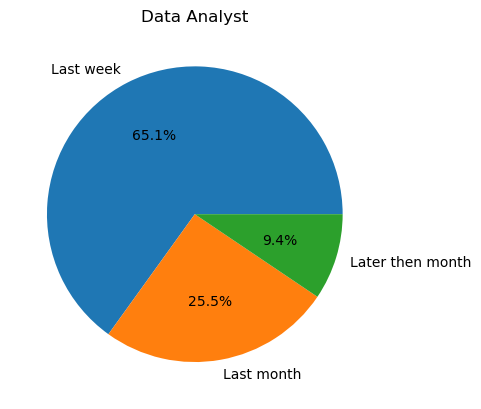

In [94]:
labels = 'Last week', 'Last month', 'Later then month'
sizes = [last_week_da, last_month_da - last_week_da, later_da]

fig, ax = plt.subplots()
plt.title('Data Analyst')
ax.pie(sizes, labels=labels, autopct='%1.1f%%');

#### Data Scientist plot

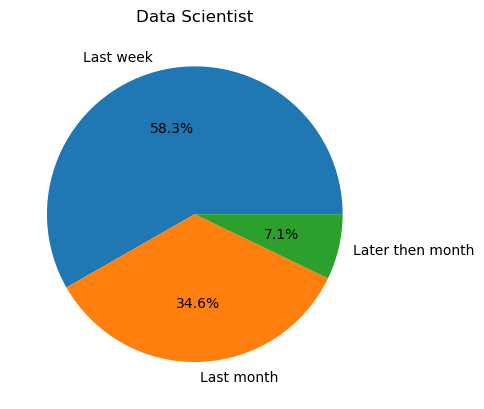

In [95]:
labels = 'Last week', 'Last month', 'Later then month'
sizes = [last_week_ds, last_month_ds - last_week_ds, later_ds]

fig, ax = plt.subplots()
plt.title('Data Scientist')
ax.pie(sizes, labels=labels, autopct='%1.1f%%');

#### Data Engineer Plot

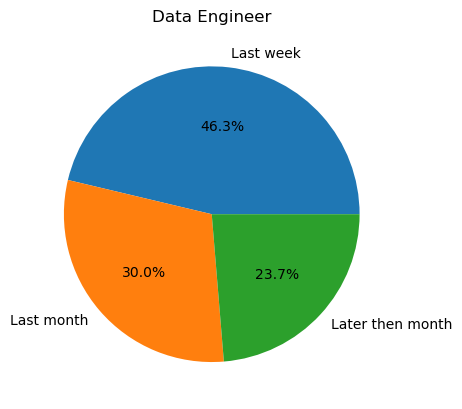

In [96]:
labels = 'Last week', 'Last month', 'Later then month'
sizes = [last_week_de, last_month_de - last_week_de, later_de]

fig, ax = plt.subplots()
plt.title('Data Engineer')
ax.pie(sizes, labels=labels, autopct='%1.1f%%');

### Seniority Level

#### Data Analyst

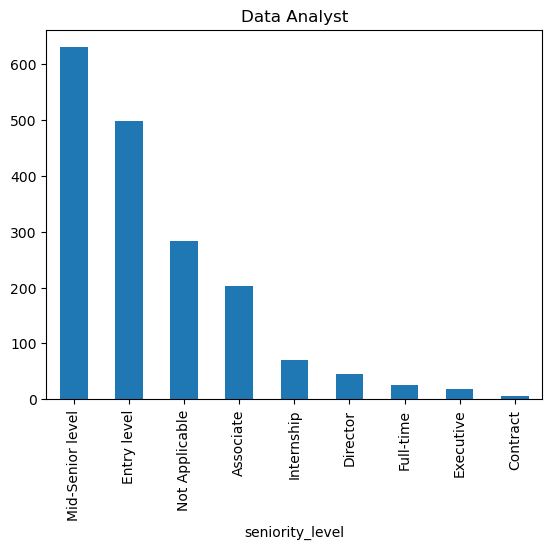

In [97]:
df[df['category'] == 'Data Analyst'].value_counts('seniority_level').plot(kind='bar', title= 'Data Analyst');

#### Data Scientist

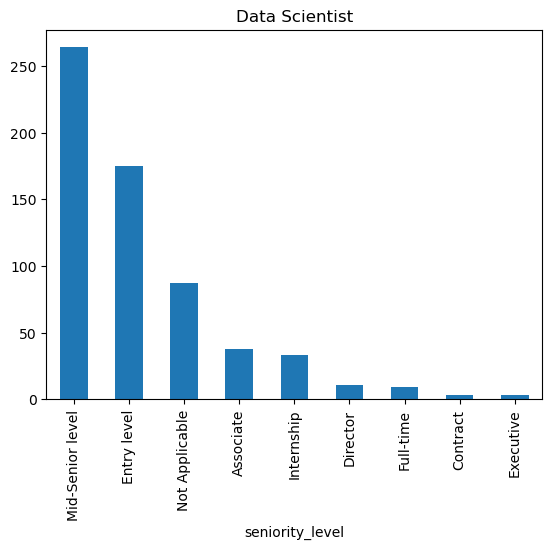

In [98]:
df[df['category'] == 'Data Scientist'].value_counts('seniority_level').plot(kind='bar', title= 'Data Scientist');

#### Data Engineer

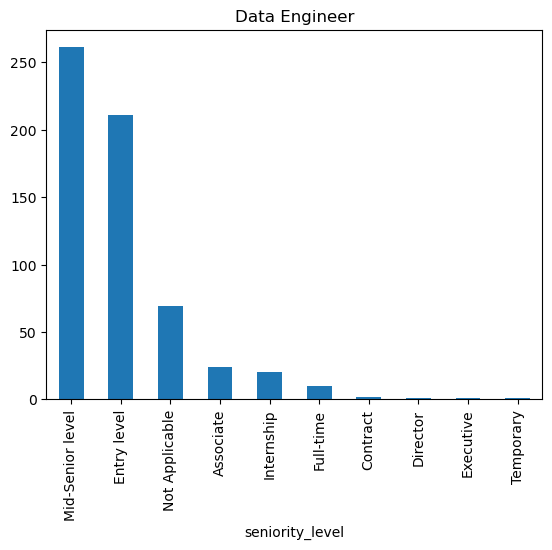

In [99]:
df[df['category'] == 'Data Engineer'].value_counts('seniority_level').plot(kind='bar', title= 'Data Engineer');